In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import galsim
from tqdm import tqdm
from censai.data.cosmos.decode_cosmos import decode_image, preprocess_image
from astropy.visualization import ImageNormalize, LogStretch
from scipy.signal import tukey
plt.style.use('dark_background')


In [9]:
def one_over_eta(rs, fs, R):
    return ((np.pi*R**2) / (np.sum(fs[rs<=R]))) * fs[rs==R]

def petrosian_radius(rs, fs):
    r_candidates = np.array([one_over_eta(rs, fs, R) for R in rs])
    return rs[np.square(r_candidates-0.2).argmin()]

def petrosian_flux(rs, fs, R_p):
    return np.sum(fs[rs<=2*R_p])

def R_x(rs, fs, x):
    x /= 100
    sum_ratio = np.cumsum(fs)/np.sum(fs)
    return rs[np.square(sum_ratio-x).argmin()]

def petrosian_Re(R_50, R_90):
    P_3 = 8e-6
    P_4 = 8.47
    return R_50 / (1 - P_3*(R_90/R_50)**P_4)

xs, ys = np.meshgrid(np.arange(128), np.arange(128))

def R_50(image):
    cy, cx = np.unravel_index(np.argmax(image), image.shape)
    xs, ys = np.meshgrid(np.arange(image.shape[0]), np.arange(image.shape[1]))
    rs = np.sqrt(np.square(xs-cx)+np.square(ys-cy))
    rs = rs.flatten()
    sorted_rs = np.argsort(rs)
    fs = image.ravel()
    rs = rs[sorted_rs]
    fs = fs[sorted_rs]
    return R_x(rs, fs, 50)

In [19]:
# datapath = "/home/aadam/scratch/Censai/data/cosmos_23.5/"
datapath = "/home/aadam/scratch/Censai/data/cosmos_23.5_preprocessed_highSNR_verydiffuse/"
# datapath = "/home/aadam/scratch/Censai/data/cosmos_23.5_preprocessed_highSNR_diffuse/"

files = glob.glob(os.path.join(datapath, "*.tfrecords"))
files = tf.data.Dataset.from_tensor_slices(files)
dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x), block_length=1, num_parallel_calls=tf.data.AUTOTUNE).map(decode_image).map(preprocess_image)

In [20]:
images = []
p_r = []
i = 0
for example in tqdm(dataset):
    i += 1
    p_r.append(R_50(example[..., 0].numpy()))
    if i <= 1000:
        images.append(example)
print(i)

3649it [00:10, 340.99it/s]

3649


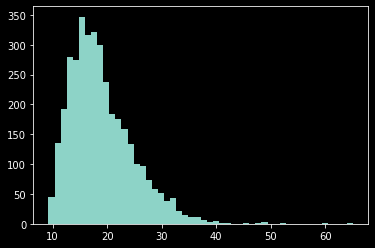

In [21]:
plt.hist(p_r, bins=50);

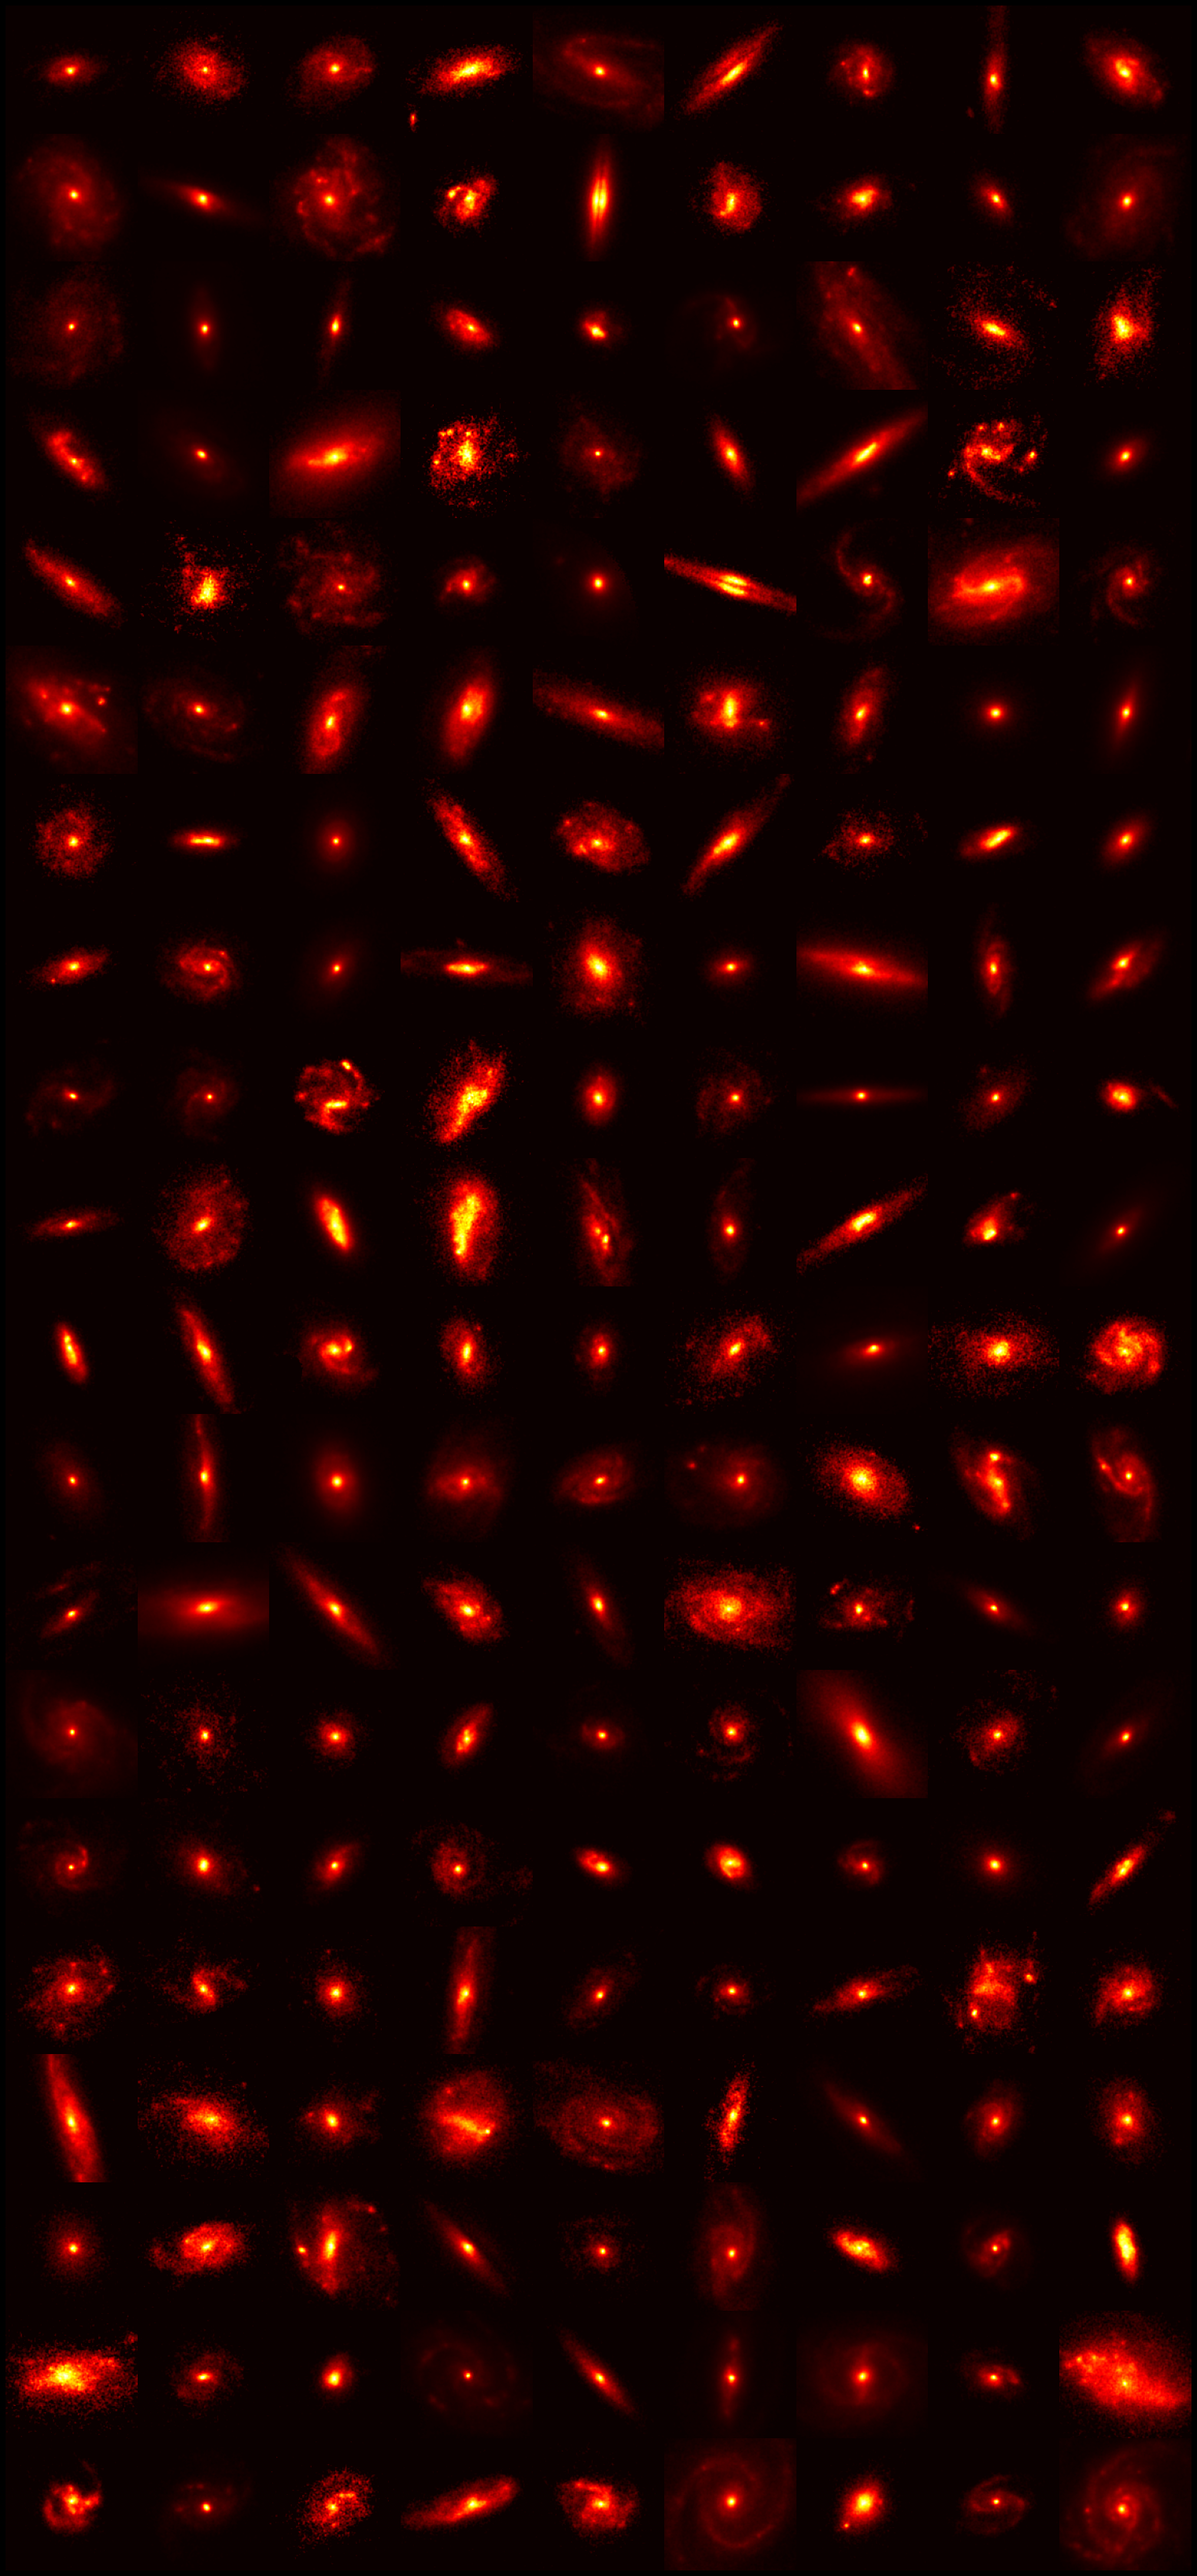

In [24]:
len_y = 20
len_x = 9
fig, axs = plt.subplots(len_y, len_x, figsize=(3 * len_x, 3 * len_y))
start = 100
for i in range(len_y):
    for j in range(len_x):
        k = i * len_x + j
        im = images[k+start][..., 0]
#         r_50 = R_50(im.numpy())
#         cy, cx = np.unravel_index(np.argmax(im), im.shape)
#         make_cir = lambda r,c: plt.Circle((cx, cy), r, color=c, fill=False)
#         cir_R_50 = make_cir(r_50, 'w')
#         axs[i, j].add_artist(cir_R_50)
        cmap = "hot" if signal > 1000 else "bone"
        axs[i, j].imshow(im, cmap=cmap)
        axs[i, j].axis("off")

plt.subplots_adjust(wspace=0, hspace=-0.05)

In [26]:
catalog = galsim.COSMOSCatalog(sample="23.5", dir="/home/aadam/scratch/data/COSMOS/COSMOS_23.5_training_sample", exclusion_level="marginal", min_flux=0)
# catalog = galsim.COSMOSCatalog(sample="25.2", dir="/home/aadam/scratch/data/COSMOS/COSMOS_25.2_training_sample", exclusion_level="marginal", min_hlr=2)
cat_param = catalog.param_cat[catalog.orig_index]

pixels = 128
pixel_scale = 0.03
fov = pixels * pixel_scale

In [27]:
flux = cat_param["flux"][:, 0]

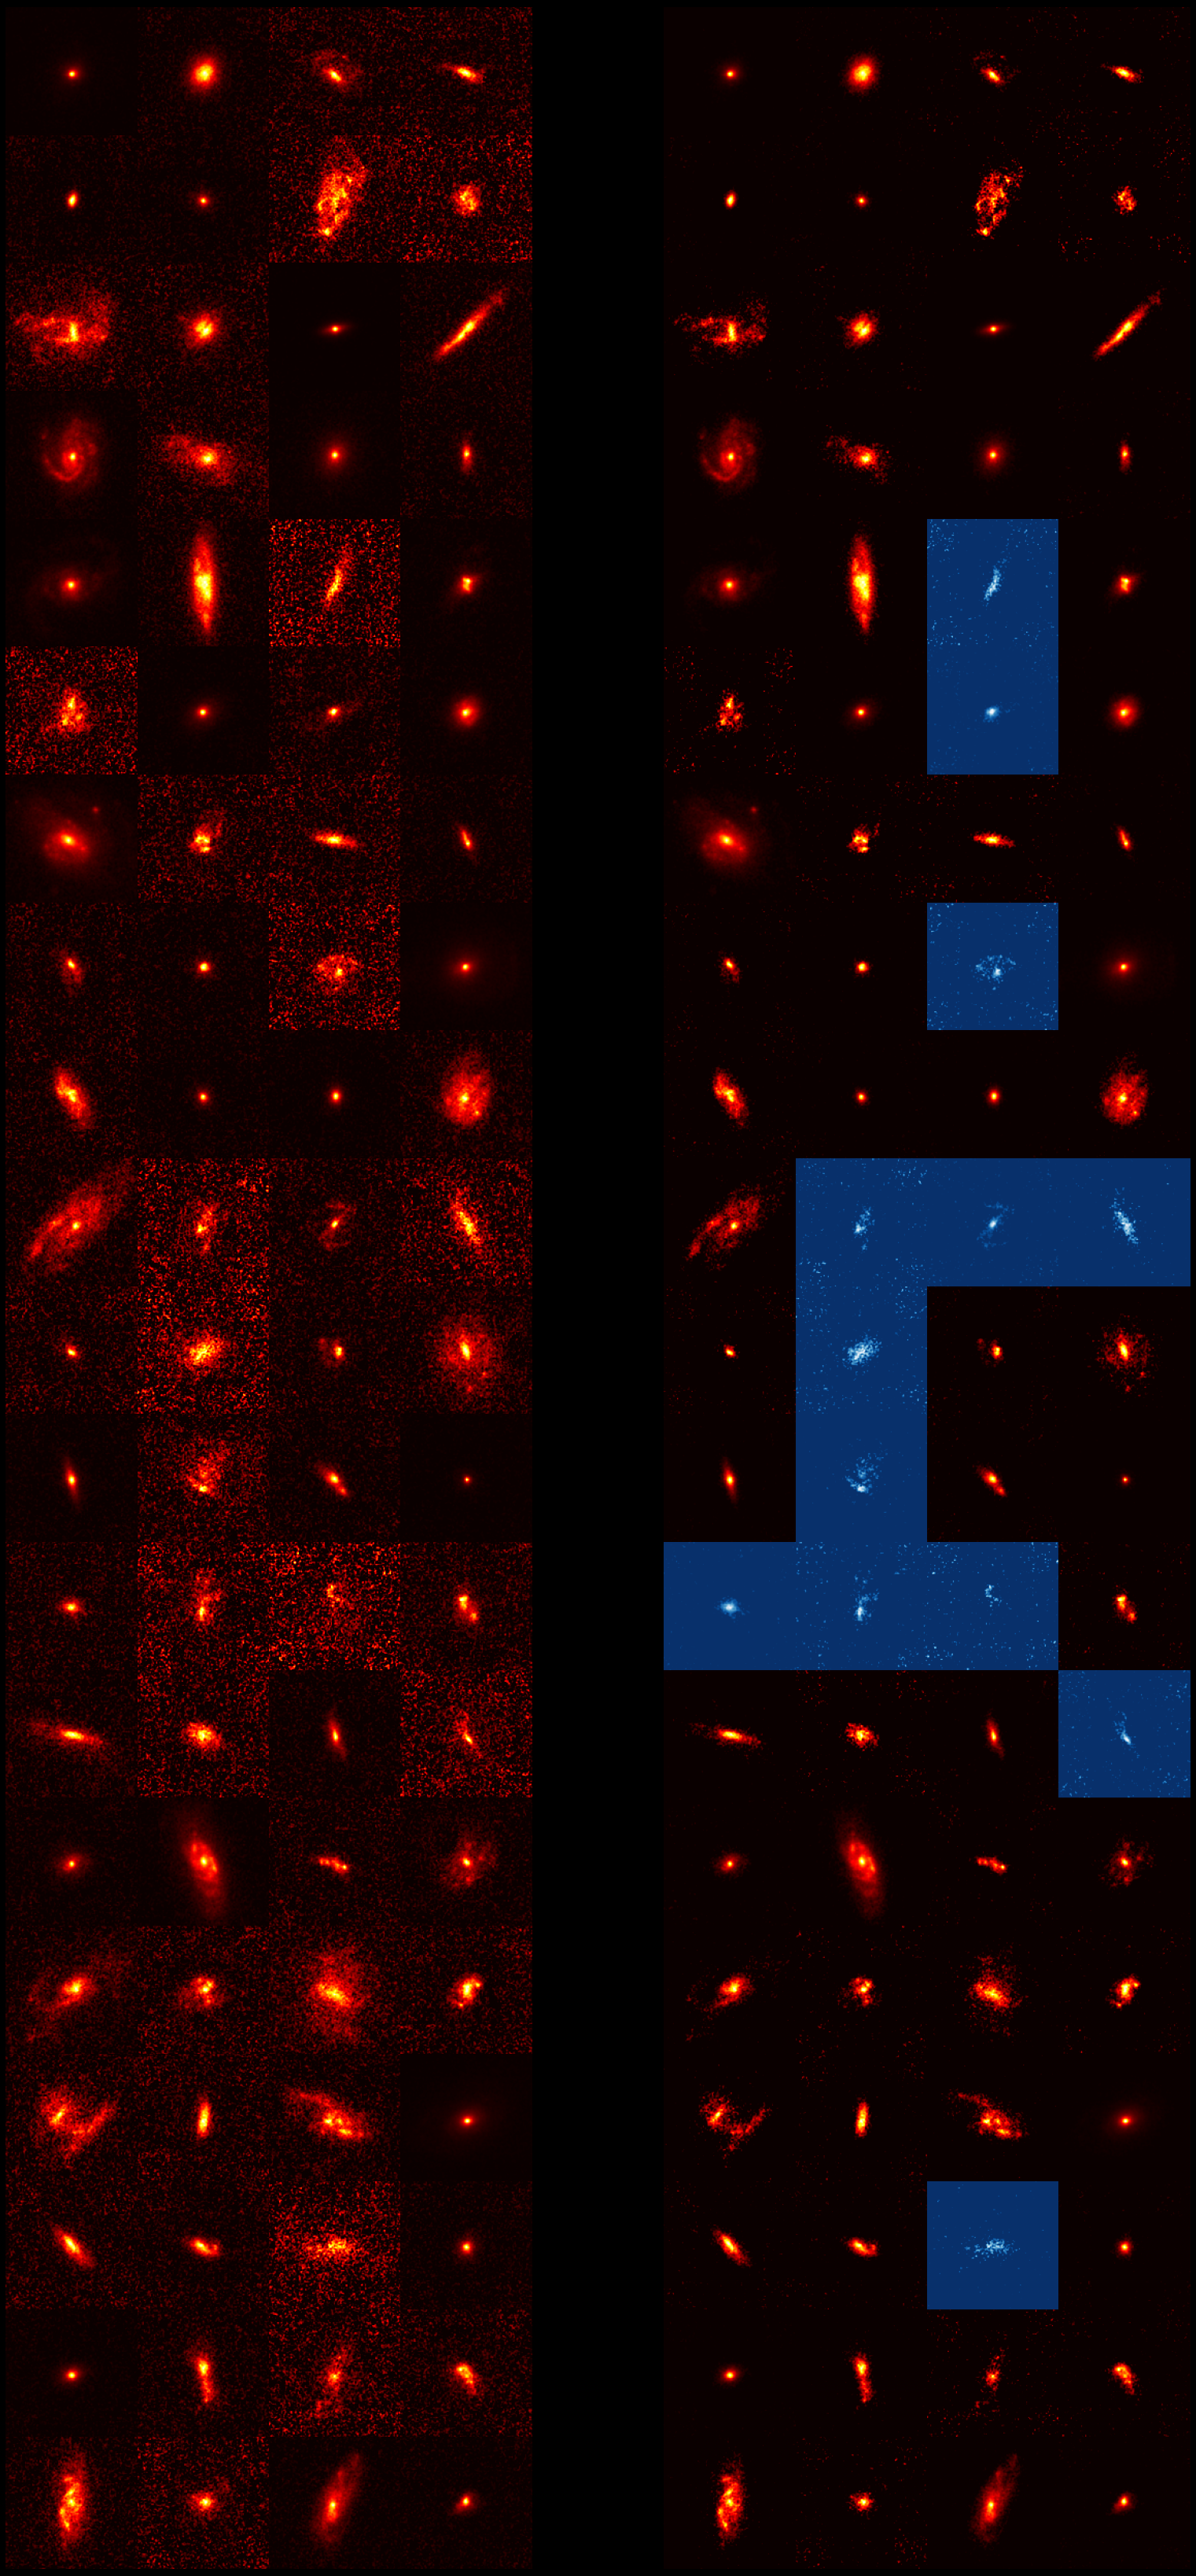

In [124]:

len_y = 20
len_x = 9
fig, axs = plt.subplots(len_y, len_x, figsize=(3 * len_x, 3 * len_y))

window = tukey(128, alpha=0.4)
window = np.outer(window, window)
flux_cutoff = 5

start = 5050
for i in range(len_y):
    for j in range(len_x//2):
        k = i * (len_x//2) + j + start
        gal = catalog.makeGalaxy(k, gal_type='real', noise_pad_size=1*pixels * pixel_scale)
        psf = gal.original_psf
        gal = galsim.Convolve(gal, psf)
        im = gal.drawImage(nx=pixels, ny=pixels, scale=pixel_scale, method='no_pixel', use_true_center=False).array.astype('float32')
        
        im = tf.nn.relu(im)
        new_flux = tf.reduce_sum(im)
#         im *= window
        im /= tf.reduce_max(im)
        
        axs[i, j].imshow(im, cmap="hot")
        axs[i, j].axis("off")
        
for i in range(len_y):
    for j in range(len_x//2+1):
        if j == 0:
            axs[i, j+len_x//2].axis("off")
            continue
        k = i * (len_x//2) + j + start - 1
        gal = catalog.makeGalaxy(k, gal_type='real', noise_pad_size=1*pixels * pixel_scale)
        psf = gal.original_psf
        gal = galsim.Convolve(gal, psf)
        im = gal.drawImage(nx=pixels, ny=pixels, scale=pixel_scale, method='no_pixel', use_true_center=False).array.astype('float32')
        
        ps = gal.noise._get_update_rootps((pixels, pixels), wcs=galsim.PixelScale(pixel_scale))
        # The following comes from correlatednoise.py
        shape = (pixels, pixels)
#         ps[0, 0] = rt2 * ps[0, 0]
        sky_bkgrd = ps[0, 0]
    
        im = tf.nn.relu(im - sky_bkgrd)
        new_flux = tf.reduce_sum(im)
#         im *= window
        im /= tf.reduce_max(im)
        if new_flux > flux_cutoff:
            cmap = "hot"
        else:
            cmap = "Blues_r"
        
        axs[i, j+len_x//2].imshow(im, cmap=cmap)
        axs[i, j+len_x//2].axis("off")


plt.subplots_adjust(wspace=0, hspace=-0.05)
plt.savefig("bkg_subtract_comparison.png")

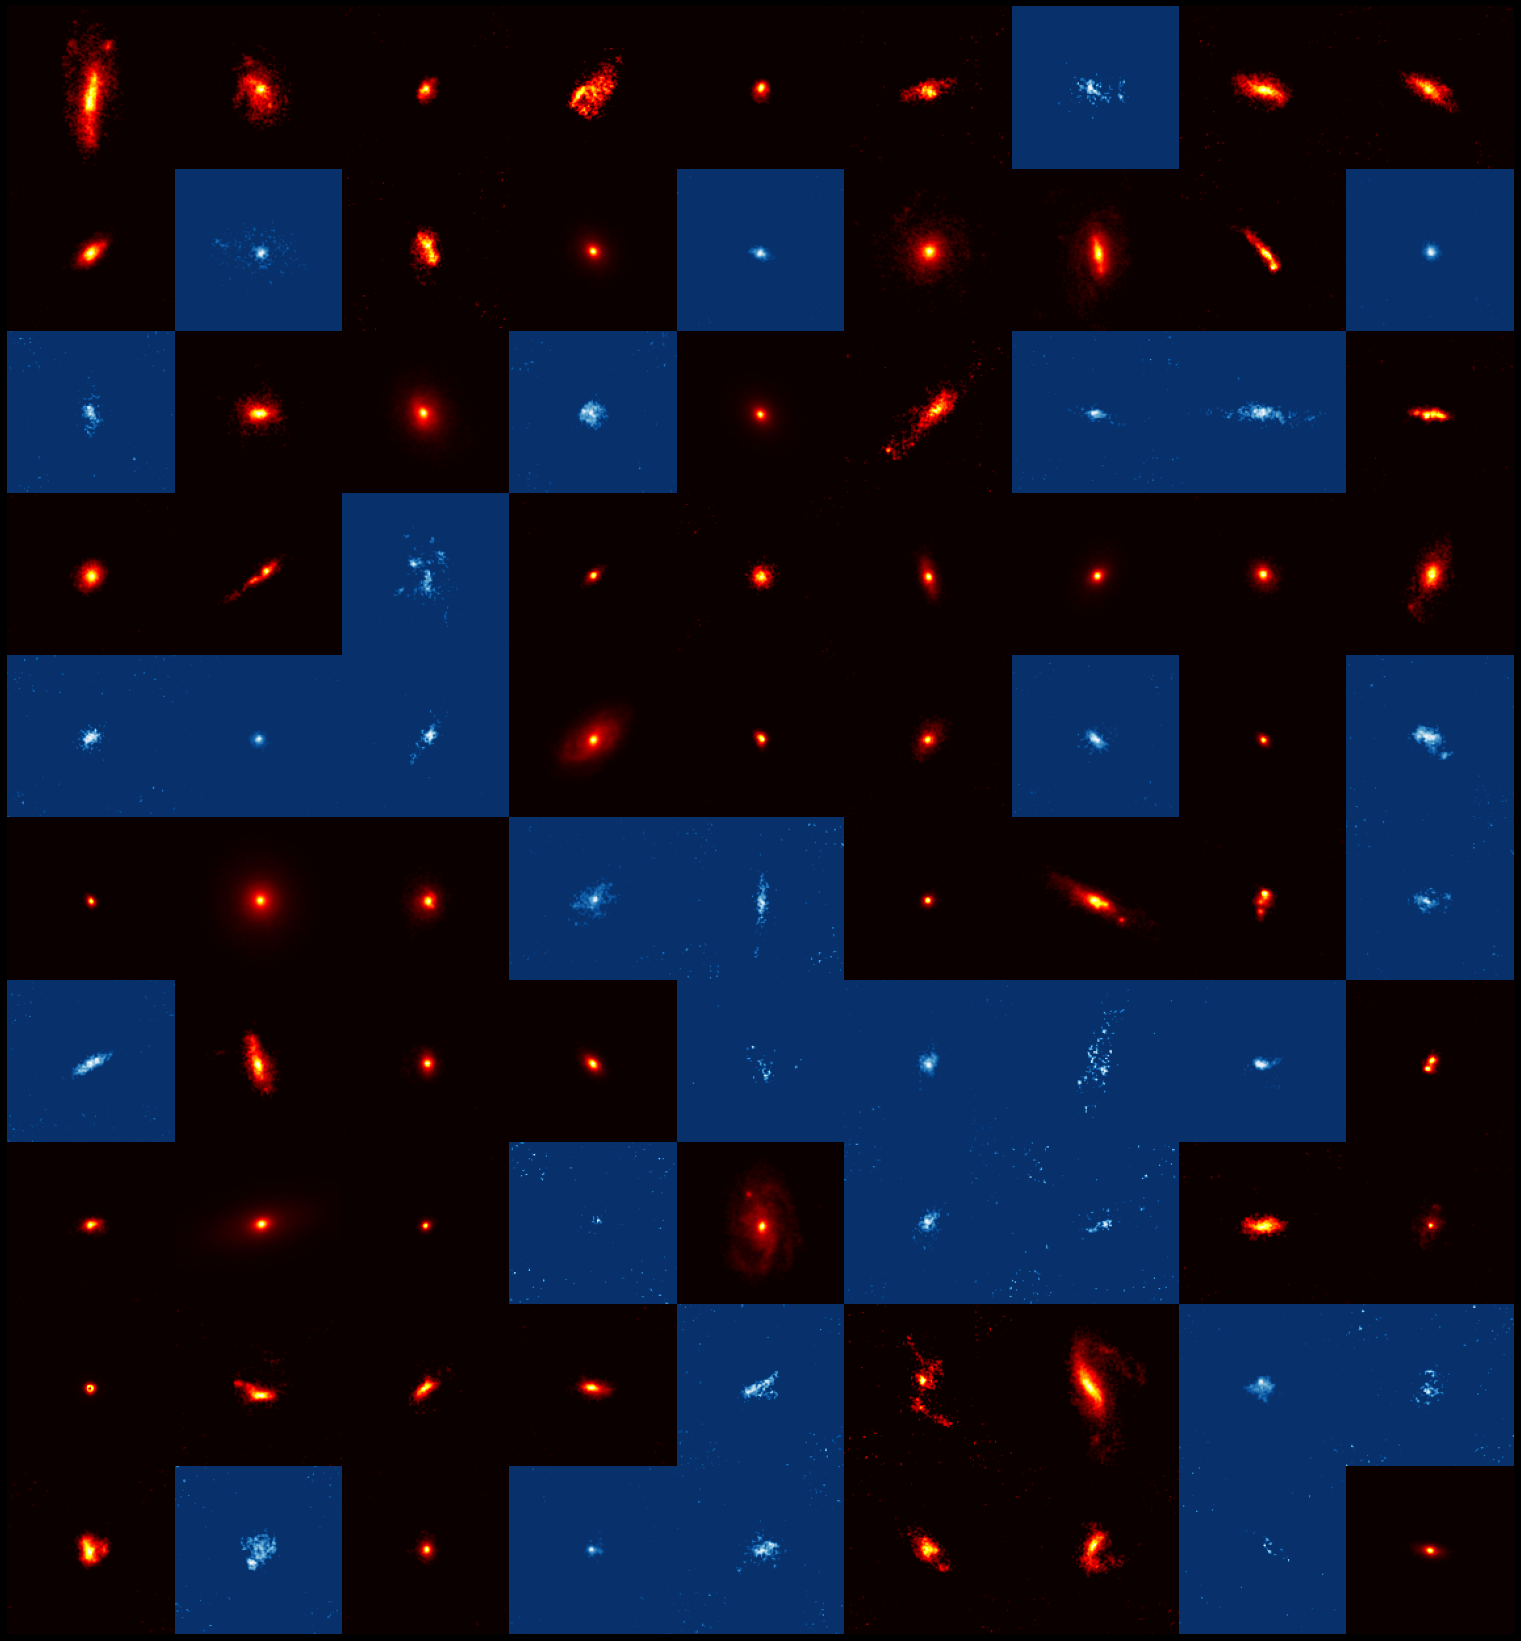

In [123]:
fig, axs = plt.subplots(len_y, len_x, figsize=(3 * len_x, 3 * len_y))

for i in range(len_y):
    for j in range(len_x):
        k = i * len_x  + j
        gal = catalog.makeGalaxy(k, gal_type='real', noise_pad_size=1*pixels * pixel_scale)
        psf = gal.original_psf
        gal = galsim.Convolve(gal, psf)
#         im = gal.drawImage().array
        im = gal.drawImage(nx=pixels, ny=pixels, scale=pixel_scale, method='no_pixel', use_true_center=False).array.astype('float32')
        
        ps = gal.noise._get_update_rootps((pixels, pixels), wcs=galsim.PixelScale(pixel_scale))
        # The following comes from correlatednoise.py
        rt2 = np.sqrt(2.)
        shape = (pixels, pixels)
        ps[0, 0] = rt2 * ps[0, 0]
        sky_bkgrd = ps[0, 0]
    
        im = tf.nn.relu(im - sky_bkgrd)
        new_flux = tf.reduce_sum(im)
        im /= tf.reduce_max(im)
#         print(new_flux)
        if new_flux > flux_cutoff:
            cmap = "hot"
        else:
            cmap = "Blues_r"
        
        axs[i, j].imshow(im, cmap=cmap)
        axs[i, j].axis("off")

plt.subplots_adjust(wspace=0, hspace=-0.05)
plt.savefig("cosmos_bkgsubtract_flux_filters.png")

In [106]:
newcf = galsim.Image(128, 128, wcs=galsim.PixelScale(pixel_scale), dtype=float)
im = gal.noise.drawImage(newcf)

# Since we just drew it, save the variance value for posterity.
var = newcf(newcf.bounds.center)


# Then calculate the sqrt(PS) that will be used to generate the actual noise.  First do
# the power spectrum (PS)
ps = np.fft.rfft2(newcf.array)

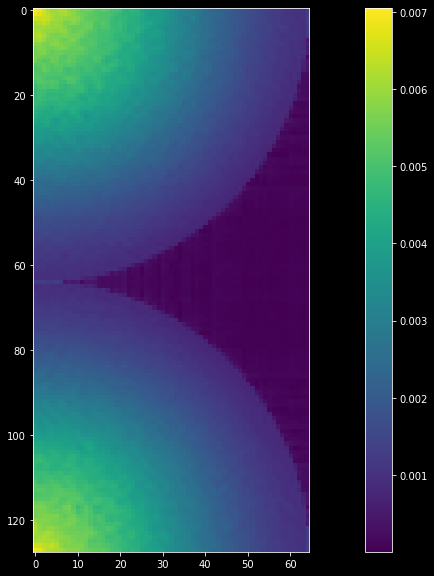

In [107]:
plt.figure(figsize=(20, 10))
plt.imshow(np.sqrt(np.abs(ps)))
plt.colorbar()

In [108]:
np.sqrt(var)

0.002541219785284052

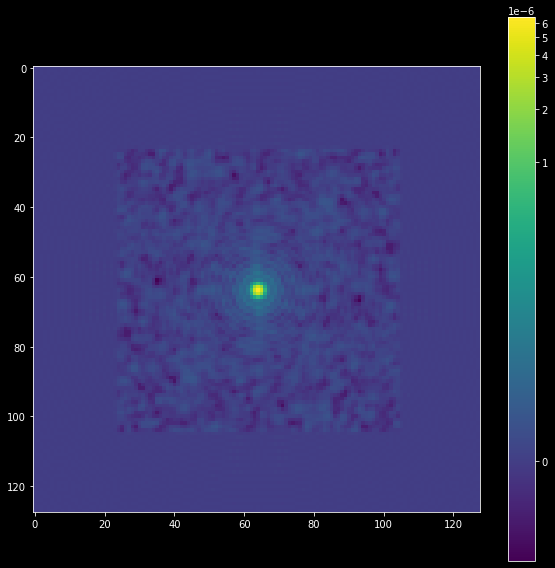

In [122]:
plt.figure(figsize=(10, 10))
plt.imshow(im.array, norm=ImageNormalize(stretch=LogStretch()))
plt.colorbar()

In [118]:
np.sqrt(np.abs(ps))[0, 0]

0.007047245590908252

In [119]:
ps1 = gal.noise._get_update_rootps((pixels, pixels), wcs=galsim.PixelScale(pixel_scale))

In [120]:
ps1[0, 0]

0.007047245590908252